# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruiting_costs`, `salary_grid`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2 as psycopg2
from psycopg2 import OperationalError

con = psycopg2.connect(
  database="human_resources", 
  user="readonly", 
  password="6hajV34RTQfmxhS", 
  host="dsstudents.skillbox.ru", 
  port="5432"
) 
 
print("Database opened successfully")
cur = con.cursor()  
cur.execute("select column_name,data_type from information_schema.columns where table_name = 'hr_dataset'")
df_hr_index = pd.DataFrame(cur.fetchall())
hr_in_l = df_hr_index[0].tolist()

cur.execute('select * from hr_dataset')
df_hr=pd.DataFrame(cur.fetchall())
df_hr.columns = hr_in_l

cur.execute("select column_name,data_type from information_schema.columns where table_name = 'production_staff'")
df_pr_index = pd.DataFrame(cur.fetchall())
pr_in_l = df_pr_index[0].tolist()

cur.execute('select * from production_staff')
df_pr = pd.DataFrame(cur.fetchall())
df_pr.columns = pr_in_l

cur.execute("select column_name,data_type from information_schema.columns where table_name = 'recruiting_costs'")
df_rc_index = pd.DataFrame(cur.fetchall())
rc_in_l = df_rc_index[0].tolist()

cur.execute('select * from recruiting_costs')
df_rc = pd.DataFrame(cur.fetchall())
df_rc.columns = rc_in_l

cur.execute("select column_name,data_type from information_schema.columns where table_name = 'salary_grid'")
df_sg_index = pd.DataFrame(cur.fetchall())
sg_in_l = df_sg_index[0].tolist()

cur.execute('select * from salary_grid')
df_sg = pd.DataFrame(cur.fetchall())
df_sg.columns = sg_in_l
df_hr.head()
#df_rc.head()
#df_pr.head()
#df_sg.head()
print(df_hr.columns.tolist())

Database opened successfully
['id', 'Employee Name', 'Employee Number', 'marriedid', 'maritalstatusid', 'genderid', 'empstatus_id', 'deptid', 'perf_scoreid', 'age', 'Pay Rate', 'state', 'zip', 'dob', 'sex', 'maritaldesc', 'citizendesc', 'Hispanic/Latino', 'racedesc', 'Date of Hire', 'Days Employed', 'Date of Termination', 'Reason For Term', 'Employment Status', 'department', 'position', 'Manager Name', 'Employee Source', 'Performance Score']


In [ ]:
cur.execute(
    '''SELECT "Performance Score", COUNT(*) FROM hr_dataset GROUP BY "Performance Score" ORDER BY COUNT  
    '''
)
dep = pd.DataFrame(cur.fetchall())
dep


,0,1
0,Exceptional,9
1,PIP,9
2,Needs Improvement,15
3,Exceeds,28
4,90-day meets,31
5,N/A- too early to review,37
6,Fully Meets,181


Проверяем гипотезу, что сть зависимость между perfomance score и тем, под чьим руководством работает сотрудник.
Для этого введем коэффициент для сравнения результата приема на работу. Этим коэффициентом будет отношение "Fully Meets" к общему числу прошедших кондидатов на прием

In [ ]:
cur.execute(
    '''
    SELECT MN, FM * 1.0 / fully AS Result
    FROM 
    (
    SELECT "Manager Name" AS MN, COUNT(*) filter (WHERE "Performance Score" = 'Fully Meets') AS FM, COUNT(*) AS fully
    FROM hr_dataset
    GROUP BY "Manager Name"
    ) AS Fr_dump  
    ORDER BY Result
    '''
)
F_meets = pd.DataFrame(cur.fetchall())
F_meets.head()

,0,1
0,Simon Roup,0.35294117647058823529
1,Brannon Miller,0.38095238095238095238
2,Michael Albert,0.40909090909090909091
3,Peter Monroe,0.42857142857142857143
4,Alex Sweetwater,0.44444444444444444444


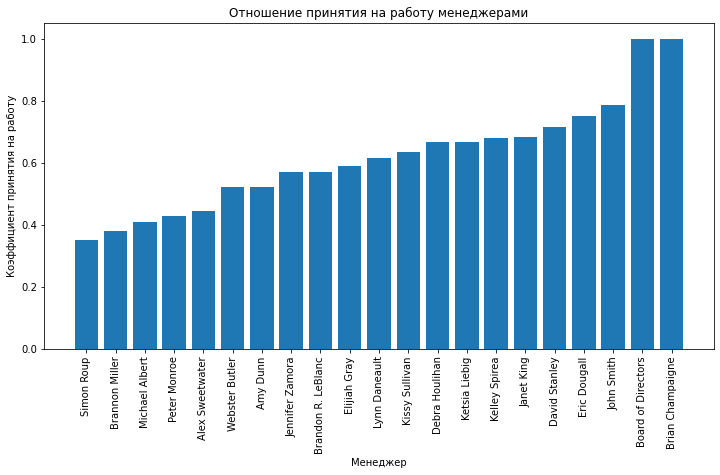

In [ ]:
fig,ax = plt.subplots(figsize=(12,6)) # задаем размер графика
ax.bar(F_meets[0], F_meets[1]) # выбираем тип графика и используемые данные

# формируем обозначения графика
ax.set_title('Отношение принятия на работу менеджерами')
ax.set_xlabel('Менеджер')
ax.set_ylabel('Коэффициент принятия на работу')
ax.tick_params(axis='x', rotation=90)
# выводим результат
plt.show()

По результату применения коэффициента видно, что действительно есть зависимость между perfomance score и тем, под чьим руководством работает сотрудник. Хуже всех с приемом справляется Simon Roup, а лучше Brian Champaigne и Board of Directors

In [ ]:
cur.execute(
    '''
    SELECT MN, FM * 1.0 / fully AS Result
    FROM 
    (
    SELECT "Manager Name" AS MN, COUNT(*) filter (WHERE "Performance Score" = 'Fully Meets') AS FM, COUNT(*) AS fully
    FROM production_staff
    GROUP BY "Manager Name"
    ) AS Pr_dump  
    ORDER BY Result
    '''
)
P_meets = pd.DataFrame(cur.fetchall())
P_meets.head()

,0,1
0,None,0E-20
1,Brannon Miller,0.38095238095238095238
2,Michael Albert,0.43478260869565217391
3,Amy Dunn,0.52380952380952380952
4,Webster Butler,0.52380952380952380952


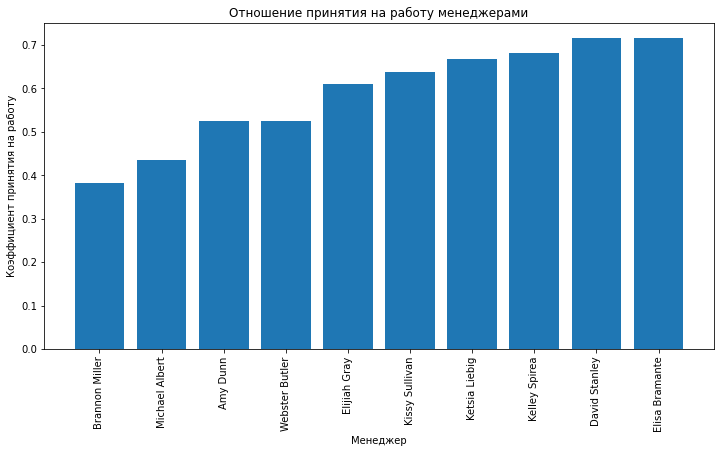

In [ ]:
P_meets = P_meets.dropna()
fig,ax = plt.subplots(figsize=(12,6)) # задаем размер графика
ax.bar(P_meets[0], P_meets[1]) # выбираем тип графика и используемые данные

# формируем обозначения графика
ax.set_title('Отношение принятия на работу менеджерами')
ax.set_xlabel('Менеджер')
ax.set_ylabel('Коэффициент принятия на работу')
ax.tick_params(axis='x', rotation=90)
# выводим результат
plt.show()

Также в среде product staff проверили эффективность работы менеджеров. Видно, что лучше всео справляется Elisa Bramante, а хуже всех Brannon Miller

Для проверки гипотезы, что есть зависимость между продолжительностью работы в компании и семейным положением сотрудника, было принято сравнить среднее значения времени работы

In [ ]:
cur.execute(
    '''
    SELECT "marriedid", AVG("Days Employed")
    FROM hr_dataset
    GROUP BY "marriedid"
    '''
)
married = pd.DataFrame(cur.fetchall())
married

,0,1
0,0,1328.8663101604278075
1,1,1246.2357723577235772


Видимого отличия нет, женатые и неженатые сотрудники работаю в среднем одинаковое кол-во дней

Проверяем гипотезу, что есть зависимость между продолжительностью работы в компании и возрастом сотрудника, через отношение к средним дням работы

In [ ]:
cur.execute(
    '''
    SELECT "age_group", AVG("Days Employed")
    FROM (SELECT "age", "Days Employed", 
    CASE 
        WHEN "age" >= 25 AND "age" <= 30 THEN '25-30'
        WHEN "age" > 30 AND "age" <= 35 THEN '31-35'
        WHEN "age" > 35 AND "age" <= 40 THEN '36-40'
        WHEN "age" > 41 AND "age" <= 45 THEN '41-45'
        WHEN "age" > 45 AND "age" <= 50 THEN '46-50'
        WHEN "age" > 51 AND "age" <= 55 THEN '51-55'
        WHEN "age" > 55 AND "age" <= 60 THEN '56-60'
        WHEN "age" > 60 AND "age" <= 67 THEN '61-65'
        ELSE 'Other category'
    END AS "age_group"
    FROM hr_dataset) AS dump_case
    GROUP BY "age_group"
    ORDER BY "age_group"
    '''
)
age = pd.DataFrame(cur.fetchall())
age = age.dropna()
age.head()

,0,1
0,25-30,1283.7647058823529412
1,31-35,1216.4069767441860465
2,36-40,1418.1864406779661017
3,41-45,1259.3684210526315789
4,46-50,1449.4137931034482759


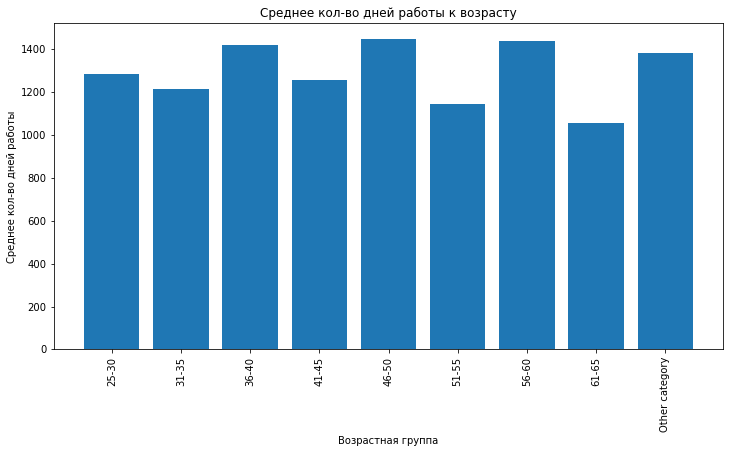

In [ ]:
fig,ax = plt.subplots(figsize=(12,6)) # задаем размер графика
ax.bar(age[0], age[1]) # выбираем тип графика и используемые данные

# формируем обозначения графика
ax.set_title('Среднее кол-во дней работы к возрасту')
ax.set_xlabel('Возрастная группа')
ax.set_ylabel('Среднее кол-во дней работы')
ax.tick_params(axis='x', rotation=90)
# выводим результат
plt.show()

Зависимости по возрасту не найдено

Проверим ряд гипотез на влияние параметров Рассы на зарплату

In [ ]:
cur.execute(
    '''
    SELECT "Race Desc", AVG(CAST("Pay" AS DECIMAL(18,3))) AS Result
    FROM production_staff
    GROUP BY "Race Desc"
    ORDER BY Result
    '''
)
Race_pay = pd.DataFrame(cur.fetchall())
Race_pay = Race_pay.dropna()
Race_pay.head()

,0,1
0,Two or more races,18.5260000000000000
1,American Indian or Alaska Native,21.8333333333333333
2,Asian,22.8045454545454545
3,White,22.9920714285714286
4,Black or African American,23.3419354838709677


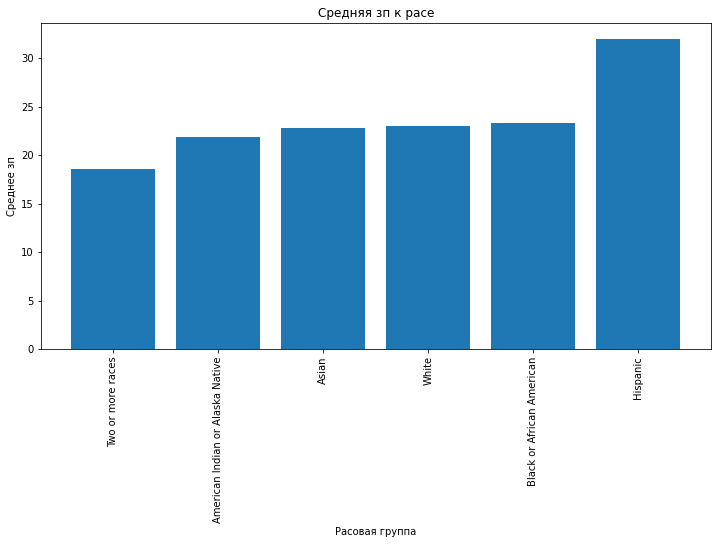

In [ ]:
fig,ax = plt.subplots(figsize=(12,6)) # задаем размер графика
ax.bar(Race_pay[0], Race_pay[1]) # выбираем тип графика и используемые данные

# формируем обозначения графика
ax.set_title('Средняя зп к расе')
ax.set_xlabel('Расовая группа')
ax.set_ylabel('Среднее зп')
ax.tick_params(axis='x', rotation=90)
# выводим результат
plt.show()

По результату видно, что больше всего зп получают люди рассы Hispanic, а люди с двумя и более получают меньше

Проанализируем влияние пола и рассы на зп

In [ ]:
cur.execute(
    '''
    SELECT "racedesc", AVG("Pay Rate") AS pay
    FROM hr_dataset
    WHERE "sex" = 'Male'
    GROUP BY "racedesc"
    ORDER BY pay
    '''
)
Race_sex_pay_male = pd.DataFrame(cur.fetchall())
Race_sex_pay_male = Race_sex_pay_male.dropna()
Race_sex_pay_male.head()

,0,1
0,White,31.595663
1,Black or African American,35.328800
2,American Indian or Alaska Native,36.000000
3,Asian,36.830769
4,Two or more races,40.465714


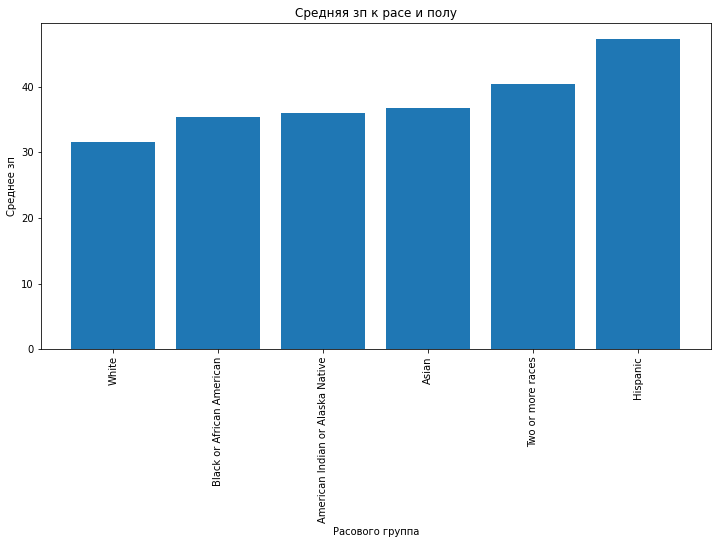

In [ ]:
fig,ax = plt.subplots(figsize=(12,6)) # задаем размер графика
ax.bar(Race_sex_pay_male[0], Race_sex_pay_male[1]) # выбираем тип графика и используемые данные

# формируем обозначения графика
ax.set_title('Средняя зп к расе и полу')
ax.set_xlabel('Расового группа')
ax.set_ylabel('Среднее зп')
ax.tick_params(axis='x', rotation=90)
# выводим результат
plt.show()

In [ ]:
cur.execute(
    '''
    SELECT "racedesc", AVG("Pay Rate") AS pay
    FROM hr_dataset
    WHERE "sex" = 'Female'
    GROUP BY "racedesc"
    ORDER BY pay
    '''
)
Race_sex_pay_female = pd.DataFrame(cur.fetchall())
Race_sex_pay_female = Race_sex_pay_female.dropna()
Race_sex_pay_female.head()

,0,1
0,Hispanic,17.000000
1,American Indian or Alaska Native,24.750000
2,Two or more races,25.409091
3,Asian,27.969524
4,White,28.651818


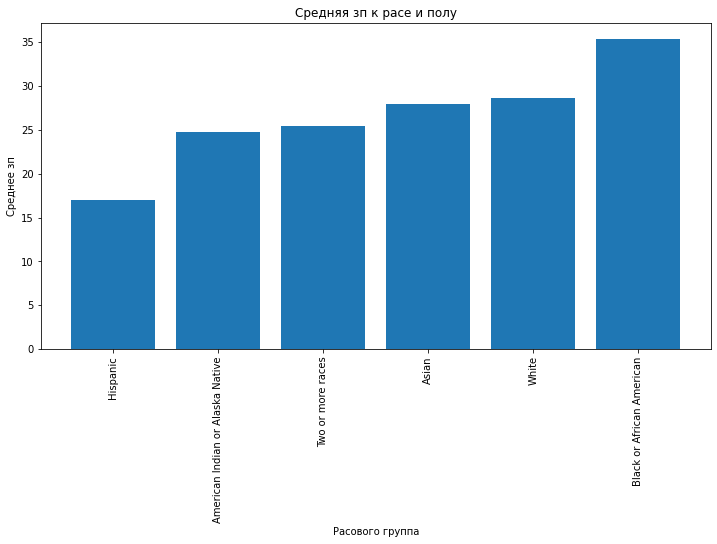

In [ ]:
fig,ax = plt.subplots(figsize=(12,6)) # задаем размер графика
ax.bar(Race_sex_pay_female[0], Race_sex_pay_female[1]) # выбираем тип графика и используемые данные

# формируем обозначения графика
ax.set_title('Средняя зп к расе и полу')
ax.set_xlabel('Расового группа')
ax.set_ylabel('Среднее зп')
ax.tick_params(axis='x', rotation=90)
# выводим результат
plt.show()

По приведенному анализу получается, что среди мужчин больше всего зарплату получают люди рассы Hispanic и меньше рассы White.
Среди женщин больше зарплату получают Black or Afican American и меньше всего Hispanic 

Проверим гипотезу зависимости ЗП от возраста

In [ ]:
cur.execute(
    '''
    SELECT "age_pay_group", AVG("Pay Rate")
    FROM (SELECT "age", "Pay Rate", 
    CASE 
        WHEN "age" >= 25 AND "age" <= 30 THEN '25-30'
        WHEN "age" > 30 AND "age" <= 35 THEN '31-35'
        WHEN "age" > 35 AND "age" <= 40 THEN '36-40'
        WHEN "age" > 41 AND "age" <= 45 THEN '41-45'
        WHEN "age" > 45 AND "age" <= 50 THEN '46-50'
        WHEN "age" > 51 AND "age" <= 55 THEN '51-55'
        WHEN "age" > 55 AND "age" <= 60 THEN '56-60'
        WHEN "age" > 60 AND "age" <= 67 THEN '61-65'
        ELSE 'Other category'
    END AS "age_pay_group"
    FROM hr_dataset) AS dump_case_pay
    GROUP BY "age_pay_group"
    ORDER BY "age_pay_group"
    '''
)
age_pay = pd.DataFrame(cur.fetchall())
age_pay = age.dropna()
age_pay.head()

,0,1
0,25-30,1283.7647058823529412
1,31-35,1216.4069767441860465
2,36-40,1418.1864406779661017
3,41-45,1259.3684210526315789
4,46-50,1449.4137931034482759


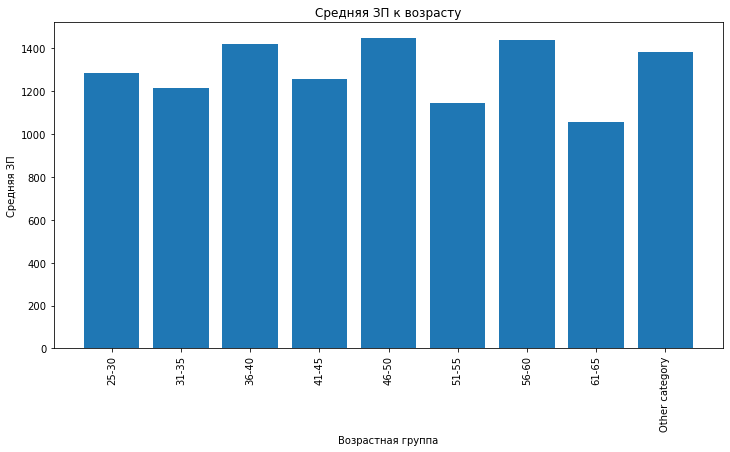

In [ ]:
fig,ax = plt.subplots(figsize=(12,6)) # задаем размер графика
ax.bar(age_pay[0], age_pay[1]) # выбираем тип графика и используемые данные

# формируем обозначения графика
ax.set_title('Средняя ЗП к возрасту')
ax.set_xlabel('Возрастная группа')
ax.set_ylabel('Средняя ЗП')
ax.tick_params(axis='x', rotation=90)
# выводим результат
plt.show()

Зависимости не обнаружено

## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://colab.research.google.com/drive/1rRaTay-OSPLAOX8V9UaFvTiAciVtp2s3).

In [ ]:
import requests
import csv
from datetime import datetime, timedelta

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response

vk_token = '6aa1c5f18b127bcaaa00ea7f80303608416188112fa60ac5e5d0a94ec23b58fe2e2399d2924e43b3674ee'


url = 'https://api.vk.com/method/account.getProfileInfo?access_token=' + str(vk_token) + '&v=5.92'
response = getjson(url)

#print(response)

# получаем последнюю запись из паблика Skillbox Вконтакте
url = 'https://api.vk.com/method/wall.get?access_token=' + str(vk_token) + '&owner_id=-66669811&offset=58&count=100&v=5.92'
response = getjson(url)
data = response['response']['items']

def file_writer(data):
    with open('skillboxlikes.csv', 'w', encoding='utf-8') as file:
        write = csv.writer(file)
        write.writerow(('data', 'time', 'likes', 'text', 'comments', 'views'))
        for post in data:
                write.writerow(((datetime.fromtimestamp(post['date']) - timedelta(hours=0)).strftime('%Y-%m-%d'),
                                (datetime.fromtimestamp(post['date']) - timedelta(hours=0)).strftime('%H:%M:%S'),                                
                                post['likes']['count'], post['text'],
                               post['comments']['count'], post['views']['count']
                               ))
            
file_writer(data)
result = pd.read_csv('skillboxlikes.csv')
result.head()


,data,time,likes,text,comments,views
0,2021-09-30,18:00:00,205,Сегодня разберем теорию цвета Иоханнеса Иттена...,0,12956
1,2021-09-30,15:34:39,30,"Что делать, если в 28 лет на работе вас называ...",0,10548
2,2021-09-30,10:25:19,45,"Согласны с Пушкиным, что осень — унылая пора? ...",2,11663
3,2021-09-29,18:00:00,155,"Как думаете, можно ли школьную программу освои...",22,16059
4,2021-09-29,10:21:06,84,Вам когда-нибудь приходила в голову мысль: «Во...,3,16333


Проведем анализ 100 постов начиная с конца сентября, чтобы можно было проверить результативность постов, начиная с предыдущего месяца

In [ ]:
import re
import pymorphy2

text_df = result
#text_df.dropna()

# разбиваем тест на слова
corpus = []
# регулярка для поиска слов
regular_expr = r'\w+'
reg_expr_compiled = re.compile(regular_expr)
# формируем датасет из отдельных слов
for raw_text in text_df.text.values.astype(str):
    # приводим к нижнему регистру
    raw_text_lower = raw_text.lower()
    # разбиваем текст на слова
    text_by_words = reg_expr_compiled.findall(raw_text_lower) 
    corpus.append(text_by_words)
        

# нормализация текста
normalized_corpus = []
morph = pymorphy2.MorphAnalyzer()
# нормализуем каждое слово в тексте
for token_list in corpus:
    normalized_token_list = []
    for word in token_list:
        parsed_token = morph.parse(word)
        normal_form = parsed_token[0].normal_form
        normalized_token_list.append(normal_form)
    normalized_corpus.append(normalized_token_list)

# превращаем в DataFrame
doc_count = len(normalized_corpus)
doc_ids = []
tokens = []
# формируем два списка-колонки датафрейма
for doc_id in range(doc_count):
    for token in normalized_corpus[doc_id]:
        doc_ids.append(doc_id)
        tokens.append(token)

tokens_df = pd.DataFrame({
    'doc_id': doc_ids,
    'word': tokens
})
# дамми-столбец
tokens_df = tokens_df.assign(dummy = 1)
# аггрегируем статистики
word_count_df = tokens_df.groupby(['doc_id','word'])['dummy'].count().reset_index()

word_count_df[word_count_df.doc_id==0].sort_values(by='dummy', ascending=False).head(10)

,doc_id,word,dummy
8,0,как,3
0,0,в,2
15,0,он,2
26,0,цвет,2
27,0,цветовой,1
25,0,художник,1
24,0,узнать,1
23,0,теория,1
22,0,статья,1
21,0,сегодня,1


In [ ]:
word_count_df_1 = word_count_df.assign(dummy_1 = 1)
word_count_df_1 = word_count_df_1.groupby(['word'])['dummy_1'].count().reset_index()
m = word_count_df_1.sort_values(by='dummy_1', ascending=False).head(10)

doc_frequency = pd.DataFrame()
doc_frequency = doc_frequency.assign(word = m['word'], d = (m['dummy_1'] / 100) * 100)
doc_frequency.head(10)

,word,d
652,и,88.0
305,в,87.0
406,вы,75.0
1642,с,71.0
963,на,64.0
209,а,62.0
1021,не,59.0
2040,что,56.0
124,https,54.0
957,мы,54.0


Проведем анализ просмотров, лайков и комментов

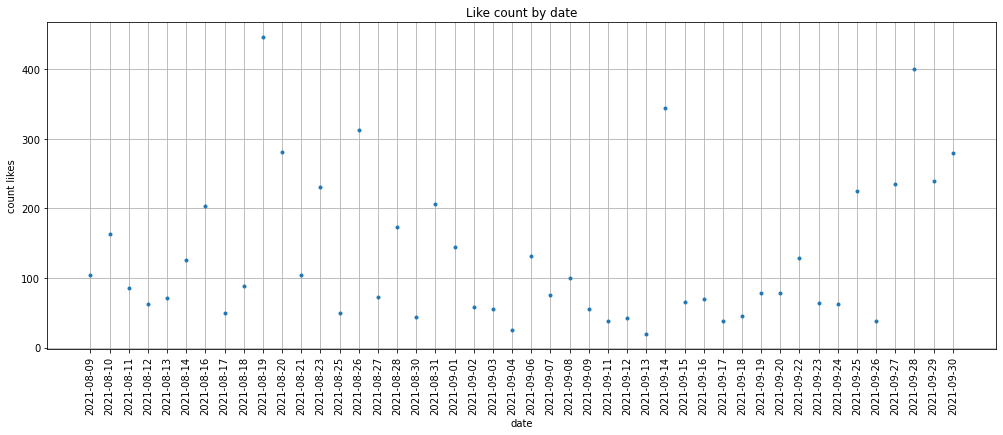

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

likes = result.groupby('data')['likes'].sum().reset_index()

plt.figure(num=1, figsize=(17, 6)) #размер отрисованного графика

plt.title('Like count by date')
plt.xlabel('date') #подпись оси x
plt.ylabel('count likes') #подпись оси y
plt.grid()
plt.xticks(rotation=90)
plt.plot(likes['data'], likes['likes'], '.') 

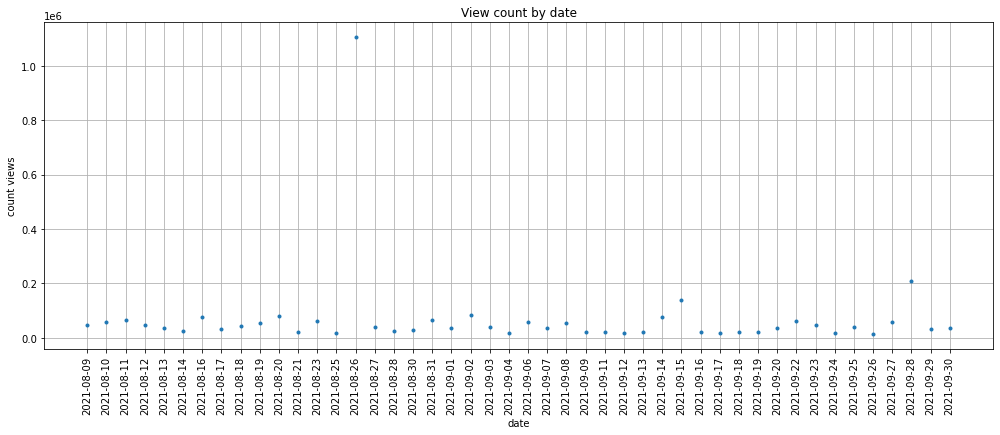

In [ ]:
views = result.groupby('data')['views'].sum().reset_index()

plt.figure(num=1, figsize=(17, 6)) #размер отрисованного графика

plt.title('View count by date')
plt.xlabel('date') #подпись оси x
plt.ylabel('count views') #подпись оси y
plt.grid()
plt.xticks(rotation=90)
plt.plot(views['data'], views['views'], '.') 

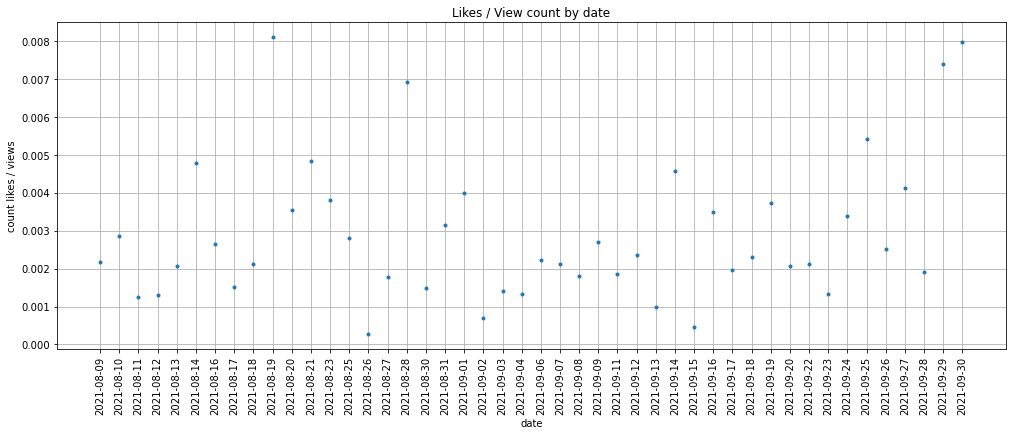

In [ ]:
likeandviews = likes.copy()
likeandviews['likes/views'] = likeandviews['likes'] / views['views']

plt.figure(num=1, figsize=(17, 6)) #размер отрисованного графика

plt.title('Likes / View count by date')
plt.xlabel('date') #подпись оси x
plt.ylabel('count likes / views') #подпись оси y
plt.grid()
plt.xticks(rotation=90)
plt.plot(likeandviews['data'], likeandviews['likes/views'], '.') 


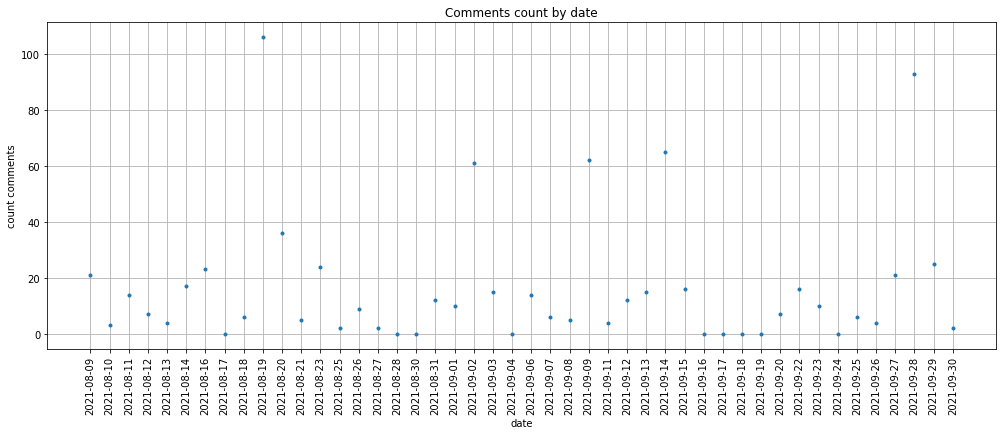

In [ ]:
comments = result.groupby('data')['comments'].sum().reset_index()

plt.figure(num=1, figsize=(17, 6)) #размер отрисованного графика

plt.title('Comments count by date')
plt.xlabel('date') #подпись оси x
plt.ylabel('count comments') #подпись оси y
plt.grid()
plt.xticks(rotation=90)
plt.plot(comments['data'], comments['comments'], '.') 

По проведенному анализу видно, что самым результативным днем был 19.08.21 - лучше всего воронка по лайкам/просмотрам и больше всего комментариев. Хуже всего воронка по лайкам/просмотрам была 26.08.21 и 15.09.21